In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,690 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,542 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import io
import datetime
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

In [ ]:
class DocumentVerificationSystem:
    def __init__(self):
        # Set up Tesseract path for Google Colab
        # Install Tesseract OCR and required packages
        print("Setting up environment...")
        !apt-get install -y tesseract-ocr
        !pip install pytesseract pandas

        # Initialize data storage
        self.verification_data = {
            'document_type': [],
            'document_number': [],
            'name': [],
            'dob': [],
            'gender': [],
            'verification_date': [],
            'verification_status': []
        }

        # Try to load existing data if file exists
        self.csv_filename = 'document_verification_data.csv'
        try:
            self.df = pd.read_csv(self.csv_filename)
            print(f"Loaded existing data with {len(self.df)} records")
        except:
            self.df = pd.DataFrame(self.verification_data)
            print("Created new CSV data storage")

        # Set up regex patterns
        self.aadhaar_pattern = r'\b[2-9]{1}[0-9]{3}\s[0-9]{4}\s[0-9]{4}\b'
        self.pan_pattern = r'\b[A-Z]{5}[0-9]{4}[A-Z]{1}\b'
        self.name_pattern = r'(?:Name|नाम)[\s:]*([A-Za-z\s]+)'
        self.dob_pattern = r'(?:DOB|Date of Birth|जन्म तिथि|Birth)[\s:]*([\d/.-]+)'
        self.gender_pattern = r'(?:(?:MALE|FEMALE|TRANSGENDER|पुरुष|महिला|M|F|Male|Female))'

    def extract_text_from_image(self, image):
        """Extract text from image using Tesseract OCR"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply thresholding to preprocess the image
        _, threshold = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

        # Extract text using Tesseract
        text = pytesseract.image_to_string(threshold, lang='eng+hin')
        return text

    def clean_text(self, text):
        """Clean extracted text for better pattern matching"""
        # Remove extra whitespaces
        cleaned = re.sub(r'\s+', ' ', text)
        # Remove special characters except those needed for date formats
        cleaned = re.sub(r'[^A-Za-z0-9\s:/.-]', '', cleaned)
        return cleaned

    def identify_document_type(self, text):
        """Identify if the document is Aadhaar or PAN"""
        if re.search(r'(?:आधार|AADHAAR|Aadhaar|UNIQUE IDENTIFICATION)', text, re.IGNORECASE):
            return "Aadhaar Card"
        elif re.search(r'(?:INCOME TAX DEPARTMENT|PAN|Permanent Account Number|आयकर विभाग)', text, re.IGNORECASE):
            return "PAN Card"
        else:
            return "Unknown Document"

    def extract_aadhaar_details(self, text):
        """Extract details from Aadhaar card"""
        details = {}

        # Extract Aadhaar number
        aadhaar_match = re.search(self.aadhaar_pattern, text)
        if aadhaar_match:
            details['document_number'] = aadhaar_match.group(0)
        else:
            # Try without spaces
            aadhaar_no_space = re.search(r'\b[2-9]{1}[0-9]{11}\b', text)
            if aadhaar_no_space:
                number = aadhaar_no_space.group(0)
                # Format it with spaces
                details['document_number'] = f"{number[:4]} {number[4:8]} {number[8:]}"

        # Extract name
        name_match = re.search(self.name_pattern, text, re.IGNORECASE)
        if name_match:
            details['name'] = name_match.group(1).strip()

        # Extract DOB
        dob_match = re.search(self.dob_pattern, text, re.IGNORECASE)
        if dob_match:
            details['dob'] = dob_match.group(1).strip()

        # Extract gender
        gender_match = re.search(self.gender_pattern, text, re.IGNORECASE)
        if gender_match:
            gender = gender_match.group(0).upper()
            if gender in ['M', 'MALE', 'पुरुष']:
                details['gender'] = 'Male'
            elif gender in ['F', 'FEMALE', 'महिला']:
                details['gender'] = 'Female'
            else:
                details['gender'] = 'Other'

        return details

    def extract_pan_details(self, text):
        """Extract details from PAN card"""
        details = {}

        # Extract PAN number
        pan_match = re.search(self.pan_pattern, text)
        if pan_match:
            details['document_number'] = pan_match.group(0)

        # Extract name
        # PAN cards usually have names in format "Name: John Doe" or just the name prominently displayed
        name_match = re.search(r'(?:Name|नाम)[:\s]*(.*?)(?:\s*DOB|\s*Date|$)', text, re.IGNORECASE)
        if name_match:
            details['name'] = name_match.group(1).strip()
        else:
            # Try alternative pattern for name
            name_alt_match = re.search(r'\b([A-Z][A-Za-z]+\s[A-Z][A-Za-z]+(?:\s[A-Z][A-Za-z]+)?)\b', text)
            if name_alt_match:
                details['name'] = name_alt_match.group(1).strip()

        # Extract DOB
        dob_match = re.search(self.dob_pattern, text, re.IGNORECASE)
        if dob_match:
            details['dob'] = dob_match.group(1).strip()

        return details

    def validate_aadhaar(self, number):
        """Validate Aadhaar number format"""
        # Remove spaces
        number = number.replace(" ", "")

        # Check if it's 12 digits and starts with a digit from 2-9
        if re.match(r'^[2-9][0-9]{11}$', number):
            # Additional Verhoeff algorithm validation could be implemented here
            return True
        return False

    def validate_pan(self, number):
        """Validate PAN card number format"""
        # Check if it follows the format: AAAAA9999A
        if re.match(r'^[A-Z]{5}[0-9]{4}[A-Z]{1}$', number):
            return True
        return False

    def verify_document(self, doc_type, details):
        """Verify the document based on extracted details"""
        if not details.get('document_number'):
            return "Failed - No document number found"

        if doc_type == "Aadhaar Card":
            if self.validate_aadhaar(details['document_number']):
                if details.get('name') and details.get('dob'):
                    return "Verified"
                else:
                    return "Partially Verified - Missing key details"
            else:
                return "Failed - Invalid Aadhaar number format"

        elif doc_type == "PAN Card":
            if self.validate_pan(details['document_number']):
                if details.get('name'):
                    return "Verified"
                else:
                    return "Partially Verified - Missing key details"
            else:
                return "Failed - Invalid PAN number format"

        return "Failed - Unknown document type"

    def check_in_database(self, document_number):
        """Check if the document already exists in the database"""
        if document_number and not document_number == "N/A":
            mask = self.df['document_number'] == document_number
            if mask.any():
                # Get matching record
                record = self.df[mask].iloc[0]
                return True, record
        return False, None

    def save_to_csv(self):
        """Save verification data to CSV file in Colab"""
        try:
            self.df.to_csv(self.csv_filename, index=False)
            print(f"Data saved to {self.csv_filename}")
            # Make an option to download the CSV file
            download_button = widgets.Button(
                description="Download CSV File",
                button_style='primary',
                icon='download'
            )

            def on_download_clicked(b):
                files.download(self.csv_filename)

            download_button.on_click(on_download_clicked)
            display(download_button)
        except Exception as e:
            print(f"Error saving data: {e}")

    def process_document(self, image):
        """Process the document image"""
        # Extract text from image
        text = self.extract_text_from_image(image)

        # Clean text
        cleaned_text = self.clean_text(text)

        # Identify document type
        doc_type = self.identify_document_type(text)

        # Extract details based on document type
        if doc_type == "Aadhaar Card":
            details = self.extract_aadhaar_details(text)
        elif doc_type == "PAN Card":
            details = self.extract_pan_details(text)
        else:
            details = {}

        # Verify document format
        verification_status = self.verify_document(doc_type, details)

        # Add verification date
        details['verification_date'] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        details['document_type'] = doc_type
        details['verification_status'] = verification_status

        # Ensure all fields exist (even if empty)
        for field in self.verification_data.keys():
            if field not in details:
                details[field] = "N/A"

        # Check if document is already in database
        in_database, existing_record = False, None
        if 'document_number' in details and details['document_number'] != "N/A":
            in_database, existing_record = self.check_in_database(details['document_number'])

        # If not in database, add to dataframe
        if not in_database:
            self.df = pd.concat([self.df, pd.DataFrame([details])], ignore_index=True)

        return doc_type, details, verification_status, text, in_database, existing_record

    def display_results(self, image, doc_type, details, verification_status, raw_text, in_database, existing_record):
        """Display verification results"""
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Document Image: {doc_type}")
        plt.axis('off')
        plt.show()

        # Display extracted information
        print("\n" + "="*50)
        print(f"DOCUMENT VERIFICATION RESULTS: {doc_type}")
        print("="*50)

        # Display database verification result
        if in_database:
            print("📋 DATABASE CHECK: ✅ DOCUMENT ALREADY VERIFIED IN DATABASE")
            print("-"*50)
            print("Previously Verified Record:")
            for key, value in existing_record.items():
                if key not in ['verification_date', 'verification_status']:
                    print(f"{key.replace('_', ' ').title()}: {value}")
            print(f"Previous Verification Date: {existing_record['verification_date']}")
            print(f"Previous Status: {existing_record['verification_status']}")
        else:
            print("📋 DATABASE CHECK: ❌ DOCUMENT NOT FOUND IN DATABASE")
            print("-"*50)
            print(f"Format Verification Status: {verification_status}")
            print("-"*50)
            print("Extracted Details:")
            for key, value in details.items():
                if key not in ['verification_date', 'document_type', 'verification_status']:
                    print(f"{key.replace('_', ' ').title()}: {value}")

        # Create verification buttons
        if not in_database:
            self.create_verification_buttons(len(self.df) - 1)
        else:
            self.create_next_actions_buttons()

    def create_verification_buttons(self, row_index):
        """Create buttons for manual verification"""
        approve_button = widgets.Button(
            description="Approve Document",
            button_style='success',
            icon='check'
        )

        reject_button = widgets.Button(
            description="Reject Document",
            button_style='danger',
            icon='times'
        )

        view_data_button = widgets.Button(
            description="View All Data",
            button_style='info',
            icon='table'
        )

        save_button = widgets.Button(
            description="Save to CSV",
            button_style='primary',
            icon='save'
        )

        new_upload_button = widgets.Button(
            description="Upload New Document",
            button_style='warning',
            icon='upload'
        )

        def on_approve_clicked(b):
            self.df.at[row_index, 'verification_status'] = "Manually Verified"
            print("Document has been manually approved and added to database.")
            self.save_to_csv()

        def on_reject_clicked(b):
            self.df.at[row_index, 'verification_status'] = "Manually Rejected"
            print("Document has been manually rejected but added to database for reference.")
            self.save_to_csv()

        def on_view_data_clicked(b):
            print("\nDatabase Contents:")
            display(HTML(self.df.to_html()))

        def on_save_clicked(b):
            self.save_to_csv()

        def on_new_upload_clicked(b):
            clear_output()
            self.upload_image()

        approve_button.on_click(on_approve_clicked)
        reject_button.on_click(on_reject_clicked)
        view_data_button.on_click(on_view_data_clicked)
        save_button.on_click(on_save_clicked)
        new_upload_button.on_click(on_new_upload_clicked)

        display(widgets.HBox([approve_button, reject_button]))
        display(widgets.HBox([view_data_button, save_button, new_upload_button]))

    def create_next_actions_buttons(self):
        """Create buttons for actions after finding document in database"""
        view_data_button = widgets.Button(
            description="View All Database Records",
            button_style='info',
            icon='table'
        )

        new_upload_button = widgets.Button(
            description="Upload New Document",
            button_style='warning',
            icon='upload'
        )

        save_button = widgets.Button(
            description="Download Database CSV",
            button_style='primary',
            icon='download'
        )

        def on_view_data_clicked(b):
            print("\nDatabase Contents:")
            display(HTML(self.df.to_html()))

        def on_new_upload_clicked(b):
            clear_output()
            self.upload_image()

        def on_save_clicked(b):
            files.download(self.csv_filename)

        view_data_button.on_click(on_view_data_clicked)
        new_upload_button.on_click(on_new_upload_clicked)
        save_button.on_click(on_save_clicked)

        display(widgets.HBox([view_data_button, new_upload_button, save_button]))

    def upload_image(self):
        """Create upload widget for document images"""
        upload_widget = widgets.FileUpload(
            accept='image/*',
            multiple=False,
            description='Upload Document'
        )

        display(HTML("<h2>Document Verification System</h2>"))
        display(HTML("<p>Upload an Aadhaar Card or PAN Card image for verification</p>"))
        display(upload_widget)

        def on_upload_change(change):
            if upload_widget.value:
                # Get the uploaded file
                uploaded_file = next(iter(upload_widget.value.values()))
                content = uploaded_file['content']

                # Convert content to image
                image = np.array(Image.open(io.BytesIO(content)))

                # Process the document
                doc_type, details, verification_status, raw_text, in_database, existing_record = self.process_document(image)

                # Display results
                clear_output()
                self.display_results(image, doc_type, details, verification_status, raw_text, in_database, existing_record)

        upload_widget.observe(on_upload_change, names='value')

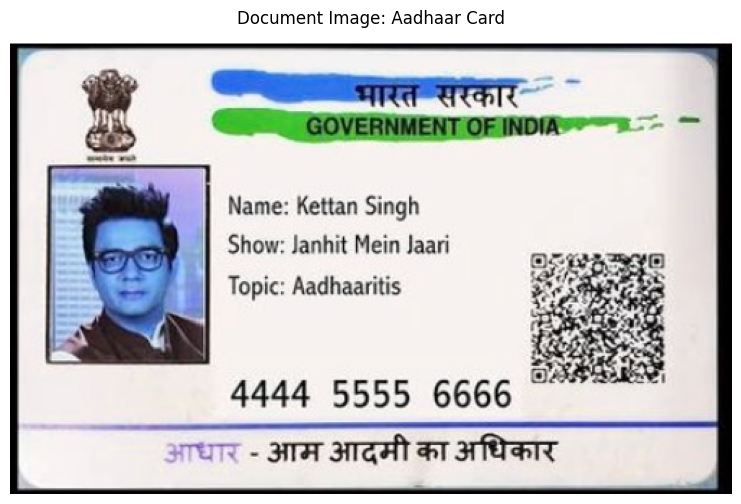


DOCUMENT VERIFICATION RESULTS: Aadhaar Card
📋 DATABASE CHECK: ✅ DOCUMENT ALREADY VERIFIED IN DATABASE
--------------------------------------------------
Previously Verified Record:
Document Type: Aadhaar Card
Document Number: 4444 5555 6666
Name: Kettan Singh
Show
Dob: N/A
Gender: Male
Previous Verification Date: 2025-04-11 11:28:38
Previous Status: Partially Verified - Missing key details


In [ ]:
system = DocumentVerificationSystem()
system.upload_image()